In [3]:
import sys, os
sys.path.append("C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝1") # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *
import mnist as mnist

# PyTorch 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### 옵티마이저 비교   

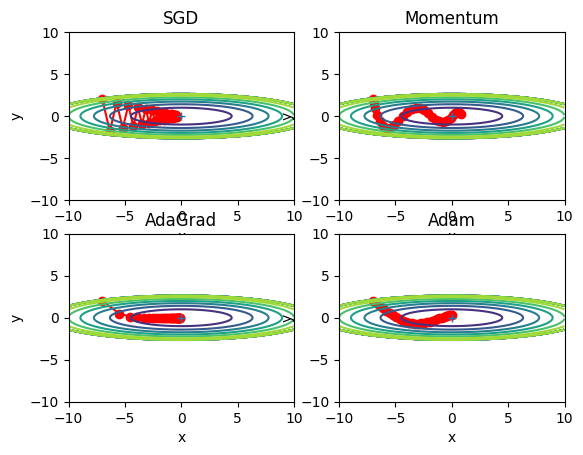

In [9]:
def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y                              # 미분 함수: x에 대한 편미분값, y에 대한 편미분값

init_pos = (-7.0, 2.0)                                  # 초기 위치
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0                           # 초기 기울기


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])   # 기울기 계산
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### mnist 데이터에 옵티마이저 성능 비교   

===========iteration:0===========
SGD:2.3258312392454386
Momentum:2.373302940134915
AdaGrad:2.248728290923615
Adam:2.102189422281458
===========iteration:100===========
SGD:1.7260460644711086
Momentum:0.32778491707668694
AdaGrad:0.13035109117291266
Adam:0.22764604919480433
===========iteration:200===========
SGD:0.9012919209644267
Momentum:0.24708411614880826
AdaGrad:0.09081433238122297
Adam:0.14631311564458893
===========iteration:300===========
SGD:0.5327239616331483
Momentum:0.15726736439511468
AdaGrad:0.08088525396811785
Adam:0.11681078783557586
===========iteration:400===========
SGD:0.6313589382105174
Momentum:0.2577311343010169
AdaGrad:0.16881104699385413
Adam:0.23409234837154425
===========iteration:500===========
SGD:0.3155179099020733
Momentum:0.09703499942860257
AdaGrad:0.0606210641311431
Adam:0.09954521907980914
===========iteration:600===========
SGD:0.2808778068717661
Momentum:0.07687069628567864
AdaGrad:0.031417764371761726
Adam:0.06139571505123
===========iteration:700=

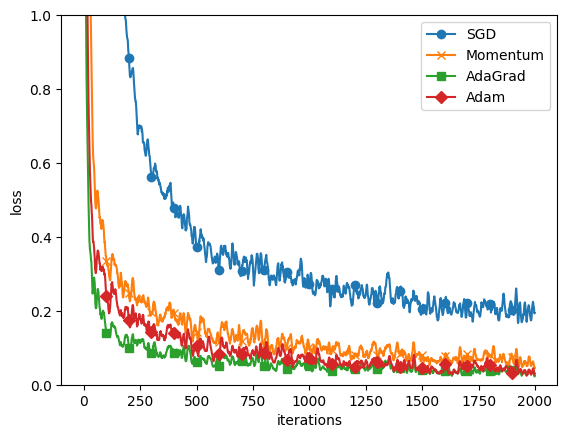

In [2]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100], # FC-Layer 4개, 노드 수: 100개
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### 내가 직접 구현해서 옵티마이저 성능 비교   

In [10]:
# 학습률은 모두 동일하게 0.01로 설정하였으나, Adam은 0.001로 설정하였다.

# Sigmoid 계층 생성
class Sigmoid:
  def __init__(self):
      self.out = None
  
  def forward(self, x):
      self.out = 1 / (1 + np.exp(-x))
      return self.out
  
  def backward(self, dout):
      dx = dout * (1 - self.out) * self.out
      return dx
      
# Relu 계층 생성
class Relu:
  def __init__(self):
    self.mask = None
    
  def forward(self, x):
    self.mask = (x <= 0)  # x가 0 이하인 원소는 True, 그 외(0보다 큰 원소)는 False
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0 # mask의 원소가 True인 곳에는 상류에서 전파된 dout을 0으로 설정
    dx = dout           
    return dx
  
# Affine 계층 생성
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.original_x_shape = None
    self.dW = None
    self.db = None
  
  def forward(self, x):
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x
    out = np.dot(self.x, self.W) + self.b
    return out
  
  def backward(self, dout):
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    dx = np.dot(dout, self.W.T)
    dx = dx.reshape(*self.original_x_shape)
    return dx
  
# softmax 함수 생성
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))
  
# Cross Entropy Error 함수 생성
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
    
# 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
  if t.size == y.size:
    t = t.argmax(axis=1)
          
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
  
# Softmax with Loss 계층 생성
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None
    
  def forward(self,x,t): # x는 출력값, t는 정답 레이블
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  
  def backward(self, dout):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
        dx = (self.y - self.t) / batch_size
    else:
        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx = dx / batch_size
    
    return dx
  
# SGD 계층 생성
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr
    
  def update(self, params, grads): # params는 가중치 리스트, grads는 기울기 리스트
    for key in params.keys():
      params[key] -= self.lr * grads[key]
 
# Momentum 계층 생성     
class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
      self.lr = lr
      self.momentum = momentum
      self.v = None
      
  def update(self, params, grads):
      if self.v is None:
          self.v = {}
          for key, val in params.items():                                
              self.v[key] = np.zeros_like(val)
              
      for key in params.keys():
          self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
          params[key] += self.v[key]
          
# AdaGrad 계층 생성
class AdaGrad:
  def __init__(self, lr=0.01):
      self.lr = lr
      self.h = None
      
  def update(self, params, grads):
      if self.h is None: # 최초 실행 시 h를 0으로 초기화
          self.h = {}
          for key, val in params.items():
              self.h[key] = np.zeros_like(val)
          
      for key in params.keys():
          self.h[key] += grads[key] * grads[key]                              # 기울기의 제곱을 누적 
          params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 각 가중치 매개변수 별로 학습률을 조정시킨다. 
          
# RMSprop 계층 생성
class RMSprop:
  def __init__(self, lr=0.01, decay_rate = 0.99):
      self.lr = lr
      self.decay_rate = decay_rate
      self.h = None
      
  def update(self, params, grads):
      if self.h is None:
          self.h = {}
          for key, val in params.items():
              self.h[key] = np.zeros_like(val)
          
      for key in params.keys():
          self.h[key] *= self.decay_rate                                   # self.decay_rate*self.h[key]
          self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]   # AdaGrad에서 (1-self.decay_rate)를 곱해주면 된다.
          params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # AdaGrad와 마찬가지로 각 가중치 매개변수 별로 학습률을 조정시킨다.
          
# Adam 계층 생성
class Adam:
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
      self.lr = lr
      self.beta1 = beta1
      self.beta2 = beta2
      self.t = 0
      self.m = None
      self.v = None
      
  def update(self, params, grads):
      if self.m is None:
          self.m = {}
          self.v = {}
          for key, val in params.items():
              self.m[key] = np.zeros_like(val)
              self.v[key] = np.zeros_like(val)
              
      self.t += 1
      for key in params.keys():
          self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key]) # 기울기의 지수 이동 평균을 계산한다.
          self.v[key] += (1 - self.beta2) * (grads[key] * grads[key] - self.v[key]) # 기울기의 제곱의 지수 이동 평균을 계산한다.
          
          m_hat = self.m[key] / (1 - self.beta1 ** self.t) # 편향 보정
          v_hat = self.v[key] / (1 - self.beta2 ** self.t) # 편향 보정
          
          params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + 1e-7) # 각 가중치 매개변수 별로 학습률을 조정시킨다.

In [11]:
class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

===========iteration:0===========
SGD:2.375108013788916
Momentum:2.5016037684688133
AdaGrad:2.2108506647338366
Adam:2.199399983390539
RMSprop:14.22925630514289
===========iteration:100===========
SGD:1.5517139172824543
Momentum:0.2613554429258961
AdaGrad:0.12211901933888153
Adam:0.16886563263963533
RMSprop:0.4067159881056608
===========iteration:200===========
SGD:0.7680786789531047
Momentum:0.22986073053929443
AdaGrad:0.11397001820727283
Adam:0.1820803098372747
RMSprop:0.2036014075019728
===========iteration:300===========
SGD:0.4909523895576873
Momentum:0.17705942012684367
AdaGrad:0.0962944796641509
Adam:0.15825942632406884
RMSprop:0.2743429814402629
===========iteration:400===========
SGD:0.4715122769124691
Momentum:0.1823595980340893
AdaGrad:0.10255018871958124
Adam:0.16946800440903337
RMSprop:0.1625815231473019
===========iteration:500===========
SGD:0.39629626084367403
Momentum:0.08548759557358873
AdaGrad:0.05270653816746105
Adam:0.10398834601178303
RMSprop:0.1798958293154564
===

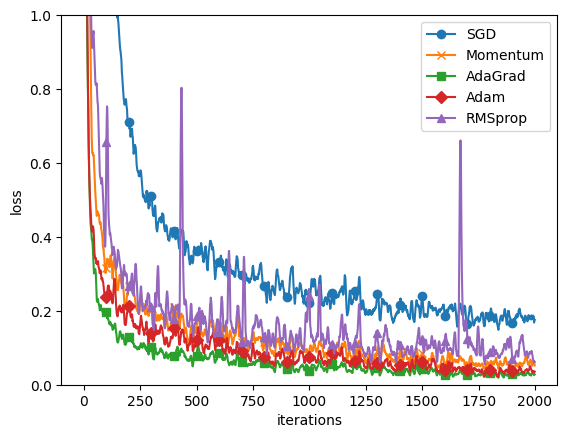

In [ ]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000
# 총 2000회 반복, 한 번 반복할 때 128개의 데이터를 사용


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
# Optimizer 별로 신경망을 생성하고, 손실 함수 값을 저장할 리스트를 생성
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100, 100],
        output_size=10)   # 은닉 층 5개, 출력층 1개인 신경망
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    # 배치 사이즈만큼 무작위로 훈련 데이터를 추출
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 반복문을 활용해 각 Optimizer를 사용해 가중치 갱신
    for key in optimizers.keys():
        # 미니 배치 별로 가중치 갱신, loss 값 계산 
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        # loss 값 계산
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    # Batch size마다 loss 값 출력
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "^"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

RSMProp은 모멘텀보다 최적점으로 도달하는데 시간이 더 오래걸린다. 이유: 모멘텀은 관성이    
또한 RMSProp의 loss가 크게 튀는 경우가 발생했는데 이는 RSMProp이 현재 time step의 기울기에 큰 영향을 받기 때문이다. 현재 time step에서 새로 누적된 기울기가 작다 보니 그 방향으로 이동을 했는데 그 곳이 loss가 최소화되는 방향이 아니었기 때문에 loss가 커진 것이다.    
SGD의 경우에는 가중치 매개변수의 기울기를 학습률에 곱해서 가중치를 조정해나가기 때문에 만약 기울기가 0으로 수렴하게 되면 더 이상 나아가지 못하고 최적점에 도달하지 못한채 학습이 끝나게 된다. 그러므로 다른 옵티마이저와 비교했을 때 가장 loss 값이 높은 것을 알 수 있었다.   
Momentum의 경우는 loss 값이 초반에 줄지 않을 수도 있었지만 이전의 기울기 크기를 고려해 가중치 매개변수의 업데이트를 이끌어내어 추가적으로 loss를 줄여나갈 수 있었다.    
Adagrad의 경우는 다른 옵티마이저보다 가장 빠르게 loss가 감소하였으나 최적점으로 도달하기까지 시간이 오래걸렸다. 그 이유는 Adagrad는 과거의 기울기를 제곱한 값을 학습률을 조정하는데 사용하는데 제곱한 값이 학습이 진행됨에 따라 점차 0으로 수렴하게 되어 학습률도 감소해 학습 진행이 느려졌기 때문이다.   
Adam의 경우는 RMSProp과 Momentum의 장점을 모두 활용해서 가중치 매개변수 갱신의 학습률을 조정해 나가기 때문에 두 옵티마이저보다 최적점으로 도달하는데 더 빠른 것을 알 수 있었다.   


### mnist 데이터를 활용하여 가중치 초기화 기법 비교   

===========iteration:0===========
std=0.01:2.302341071033429
Xavier:2.2617848733168127
He:2.2081422843232645
===========iteration:100===========
std=0.01:2.2529455777987897
Xavier:0.3234975300932271
He:0.18602862142911328
===========iteration:200===========
std=0.01:1.166537602699154
Xavier:0.28905017401895056
He:0.18108010468742874
===========iteration:300===========
std=0.01:0.5581090794179258
Xavier:0.17046596839519246
He:0.10530312733787432
===========iteration:400===========
std=0.01:0.4183883717239321
Xavier:0.22183733249460413
He:0.16729531197796188
===========iteration:500===========
std=0.01:0.2962077184602462
Xavier:0.11316178686862641
He:0.06499410861563842
===========iteration:600===========
std=0.01:0.2679171634837331
Xavier:0.17214812252359887
He:0.11330079671891219
===========iteration:700===========
std=0.01:0.1785877719164521
Xavier:0.044877680403789935
He:0.049682386128691886
===========iteration:800===========
std=0.01:0.20912899776355975
Xavier:0.12480981395107614
H

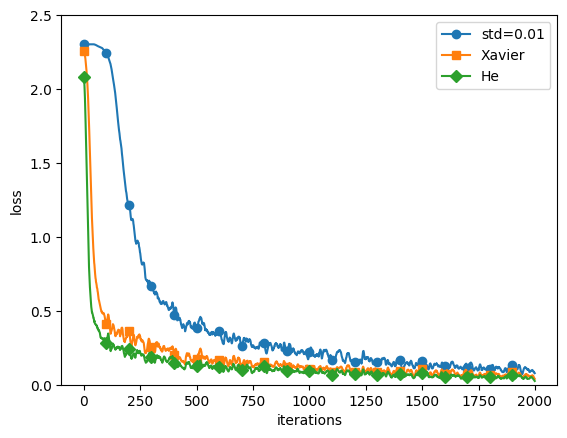

In [6]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
# 가중치 초기화 방법, 표준편차 0.01로 설정, Xavier(활성화 함수가 시그모이드인 경우), He(활성화 함수가 ReLU인 경우)
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'} 
optimizer = Adam(lr=0.001)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():  # key는 std=0.01, Xavier, He, weight_type은 0.01, sigmoid, relu
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    # 배치 사이즈만큼 무작위로 훈련 데이터 호출
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### 내가 직접 구현해서 가중치 초기화 방법 비교  

In [2]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

### 활성화 함수 relu를 사용했을 때 가중치 초기값에 따른 정확도 비교 

In [12]:


# Define the deeper neural network
# 은닉층 4개, 출력층 1개인 신경망, 각 은닉층의 노드 수는 256, 128, 64, 32, 10로 줄어든다. 
# 활성화 함수는 ReLU를 사용한다. 보통 ReLU를 사용할 때는 He 초깃값을 사용한다.
class DeeperNN(nn.Module):
    def __init__(self):
        super(DeeperNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 128)
        self.fc8 = nn.Linear(128, 128)
        self.fc9 = nn.Linear(128, 128)
        self.fc10 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = self.fc10(x)
        return x

# Define initialization methods
def initialize_weights(model, init_type, constant_value=None):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if init_type == "he":
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            elif init_type == "xavier":
                nn.init.xavier_normal_(layer.weight)
            elif init_type == "small_gaussian":
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            elif init_type == "random":
                nn.init.uniform_(layer.weight, a=-0.5, b=0.5)
            elif init_type == "constant" and constant_value is not None:
                nn.init.constant_(layer.weight, constant_value)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

# Train and evaluate
def train_and_evaluate(init_type):
    model = DeeperNN()
    initialize_weights(model, init_type)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)
    
    num_epochs = 10
    train_accuracy = []
    val_accuracy = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy.append(correct / total)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy.append(correct / total)
    
    return train_accuracy, val_accuracy

# Run experiments for different initializations
# 반복문을 통해 각 초기화 방법에 대해 학습 및 평가를 진행한다.
initializations = ["he", "xavier", "small_gaussian", "random", "same weight"]
results = {}

for init_type in initializations:
    print(f"Training with {init_type} initialization...")
    train_acc, val_acc = train_and_evaluate(init_type)
    results[init_type] = val_acc
    print(results[init_type])


Training with he initialization...


KeyboardInterrupt: 

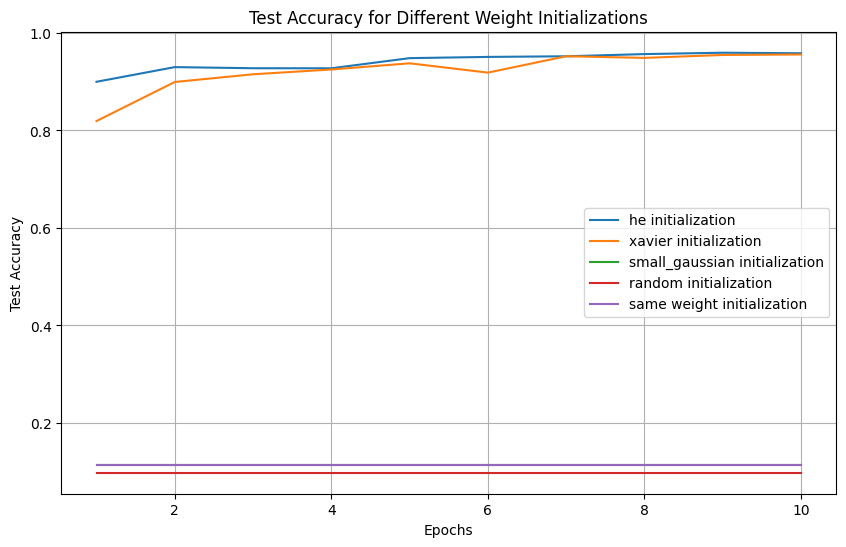

In [4]:
# Plot the results
plt.figure(figsize=(10, 6))
for init_type, val_acc in results.items():
    plt.plot(range(1, 11), val_acc, label=f'{init_type} initialization')

plt.title("Test Accuracy for Different Weight Initializations")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### 활성화 함수 tanh를 사용했을 때 가중치 초기값에 따른 정확도 비교   

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 128)
        self.fc8 = nn.Linear(128, 128)
        self.fc9 = nn.Linear(128, 128)
        self.fc10 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        x = self.fc10(x)
        return x
    
    # Define initialization methods
def initialize_weights(model, init_type):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if init_type == "he":
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            elif init_type == "xavier":
                nn.init.xavier_normal_(layer.weight)
            elif init_type == "small_gaussian":
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            elif init_type == "random":
                nn.init.uniform_(layer.weight, a=-0.5, b=0.5)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

# Train and evaluate
def train_and_evaluate(init_type):
    model = DeeperNN()
    initialize_weights(model, init_type)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)
    
    num_epochs = 10
    train_accuracy = []
    val_accuracy = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy.append(correct / total)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy.append(correct / total)
    
    return train_accuracy, val_accuracy

# Run experiments for different initializations
# 반복문을 통해 각 초기화 방법에 대해 학습 및 평가를 진행한다.
initializations = ["he", "xavier", "small_gaussian", "random"]
results = {}

for init_type in initializations:
    print(f"Training with {init_type} initialization...")
    train_acc, val_acc = train_and_evaluate(init_type)
    results[init_type] = val_acc

Training with he initialization...
Training with xavier initialization...
Training with small_gaussian initialization...
Training with random initialization...


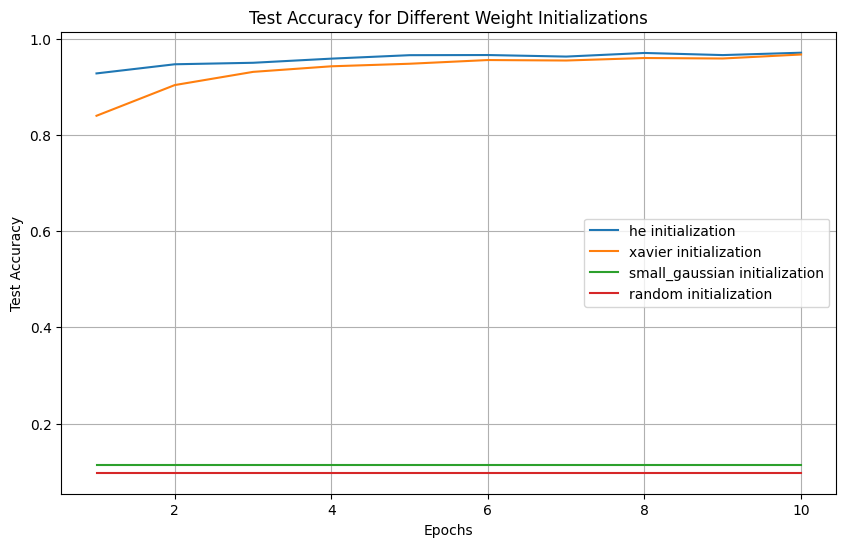

In [19]:
# Plot the results
plt.figure(figsize=(10, 6))
for init_type, val_acc in results.items():
    plt.plot(range(1, 11), val_acc, label=f'{init_type} initialization')

plt.title("Test Accuracy for Different Weight Initializations")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
class Tanh:
  def __init__(self):
      self.out = None

  def forward(self, x):
      self.out = np.tanh(x)
      return self.out

  def backward(self, dout):
      dx = dout * (1.0 - self.out ** 2)
      return dx

In [13]:
class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu, 'tanh': Tanh}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값    
            elif str(weight_init_std).lower() in ('lecun'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # LeCun 초깃값
            elif str(weight_init_std).lower() in ('tanh','xavier(tanh)'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # tanh를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # def numerical_gradient(self, x, t):
    #     """기울기를 구한다(수치 미분).
        
    #     Parameters
    #     ----------
    #     x : 입력 데이터
    #     t : 정답 레이블
        
    #     Returns
    #     -------
    #     각 층의 기울기를 담은 딕셔너리(dictionary) 변수
    #         grads['W1']、grads['W2']、... 각 층의 가중치
    #         grads['b1']、grads['b2']、... 각 층의 편향
    #     """
    #     loss_W = lambda W: self.loss(x, t)

    #     grads = {}
    #     for idx in range(1, self.hidden_layer_num+2):
    #         grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
    #         grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

    #     return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

===========iteration:0===========
std=0.01:2.302325352871515
Xavier:2.2718140122887442
He:2.210769140544376
lecun:2.290523004552176
Xavier(tanh):2.2985611002283344
===========iteration:100===========
std=0.01:2.2697229892859907
Xavier:0.5816157751272861
He:0.3514942692662031
lecun:0.6474545099646771
Xavier(tanh):0.5190951041053004
===========iteration:200===========
std=0.01:1.8875042431888311
Xavier:0.2989357954464895
He:0.19228170349302753
lecun:0.2980460895715443
Xavier(tanh):0.25577090800013436
===========iteration:300===========
std=0.01:0.9848699134700099
Xavier:0.33110411106957327
He:0.22918029755874403
lecun:0.3042002682893341
Xavier(tanh):0.28145990636419294
===========iteration:400===========
std=0.01:0.680016630302674
Xavier:0.45193809157475506
He:0.2811293575367262
lecun:0.3561147833565926
Xavier(tanh):0.37594790007115253
===========iteration:500===========
std=0.01:0.4799083055455212
Xavier:0.18079352654768838
He:0.1461240066200818
lecun:0.17444354717777405
Xavier(tanh):0.

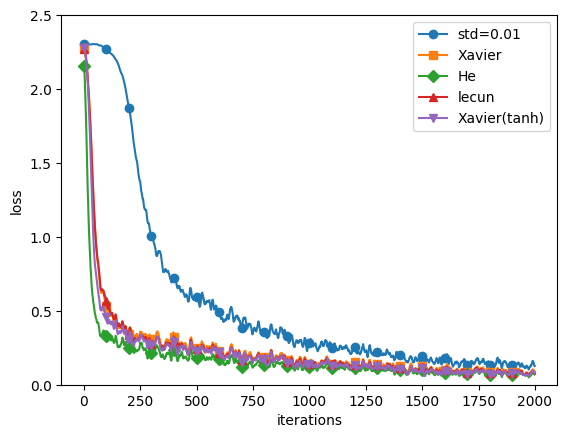

In [51]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu', 'lecun':'sigmoid', 'Xavier(tanh)':'tanh'} # 가중치 초기화 방법, 표준편차 0.01로 설정, Xavier(활성화 함수가 시그모이드인 경우), He(활성화 함수가 ReLU인 경우)
optimizer = Adam(lr=0.001)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D', 'lecun': '^', 'Xavier(tanh)': 'v'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

가중치 초기화 설정에 따른 모델 학습 성능을 비교해보았다. 평균을 0, 표준편차를 0.01로 가중치를 랜덤하게 초기화하는 방법을 제외하고 전부 학습이 잘 된 것을 볼 수 있다. 추가적으로 lecun 

### 배치 정규화 -> 각 층에서의 활성화 값을 적당히 분포시키는 방법   

In [4]:
from common.multi_layer_net_extend import MultiLayerNetExtend 

In [6]:
# MNIST 데이터 로드
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 10
train_size = x_train.shape[0]
learning_rate = 0.01
weight_scale = 0.01  # weight_scale 고정

# 변화시킬 batch_size 리스트
batch_size_list = [1,2,5,16,32,64]


def __train(batch_size):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                     weight_init_std=weight_scale, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                  weight_init_std=weight_scale)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []
    test_acc_list = []
    bn_test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            bn_test_acc = bn_network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
            test_acc_list.append(test_acc)
            bn_test_acc_list.append(bn_test_acc)

            print(f"epoch: {epoch_cnt} | Normal: {train_acc:.4f} - BatchNorm: {bn_train_acc:.4f} | Test Normal: {test_acc:.4f} - Test BatchNorm: {bn_test_acc:.4f}")

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list, test_acc_list, bn_test_acc_list

============== Batch Size: 1 ==============
epoch: 0 | Normal: 0.0990 - BatchNorm: 0.1290 | Test Normal: 0.1032 - Test BatchNorm: 0.1243
epoch: 1 | Normal: 0.1170 - BatchNorm: 0.1410 | Test Normal: 0.1028 - Test BatchNorm: 0.1341
============== Batch Size: 2 ==============
epoch: 0 | Normal: 0.0990 - BatchNorm: 0.0990 | Test Normal: 0.1032 - Test BatchNorm: 0.1032
epoch: 1 | Normal: 0.1160 - BatchNorm: 0.2050 | Test Normal: 0.1135 - Test BatchNorm: 0.2080
============== Batch Size: 5 ==============
epoch: 0 | Normal: 0.0930 - BatchNorm: 0.1040 | Test Normal: 0.1010 - Test BatchNorm: 0.1082
epoch: 1 | Normal: 0.1170 - BatchNorm: 0.6770 | Test Normal: 0.1028 - Test BatchNorm: 0.6336
============== Batch Size: 16 ==============
epoch: 0 | Normal: 0.1000 - BatchNorm: 0.1160 | Test Normal: 0.1009 - Test BatchNorm: 0.1036
epoch: 1 | Normal: 0.1170 - BatchNorm: 0.8930 | Test Normal: 0.1028 - Test BatchNorm: 0.8145
============== Batch Size: 32 ==============
epoch: 0 | Normal: 0.0930 - BatchN

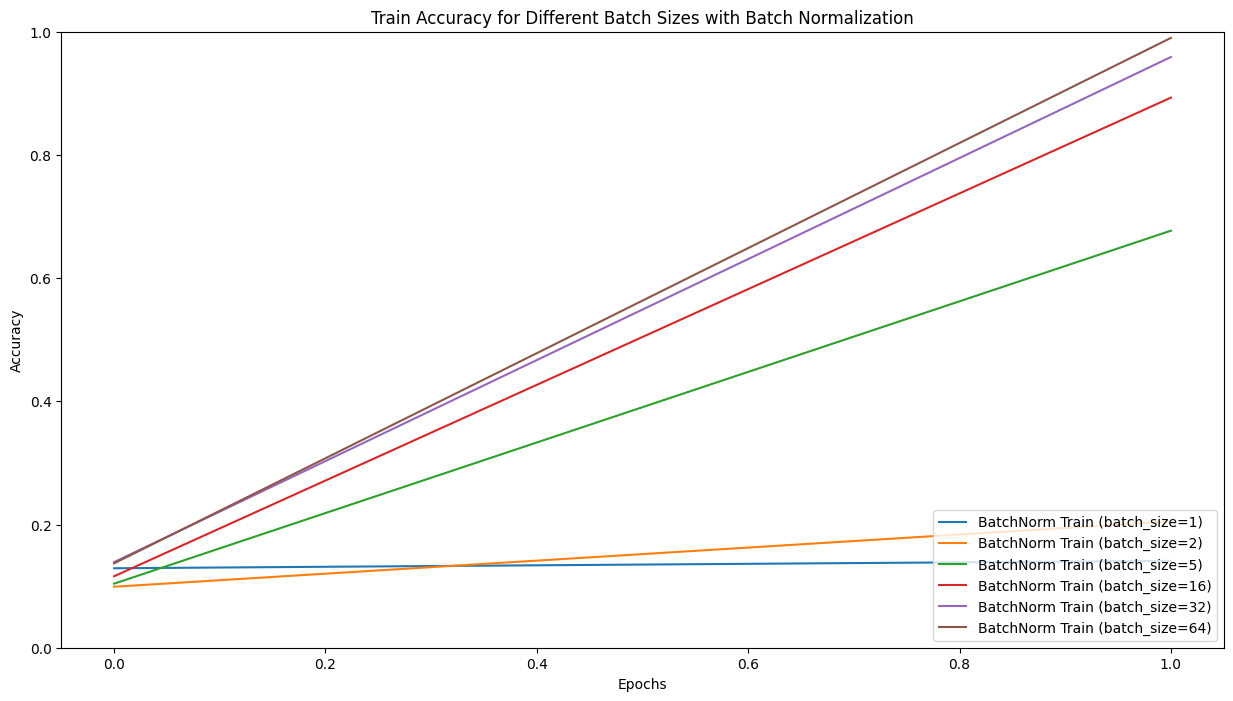

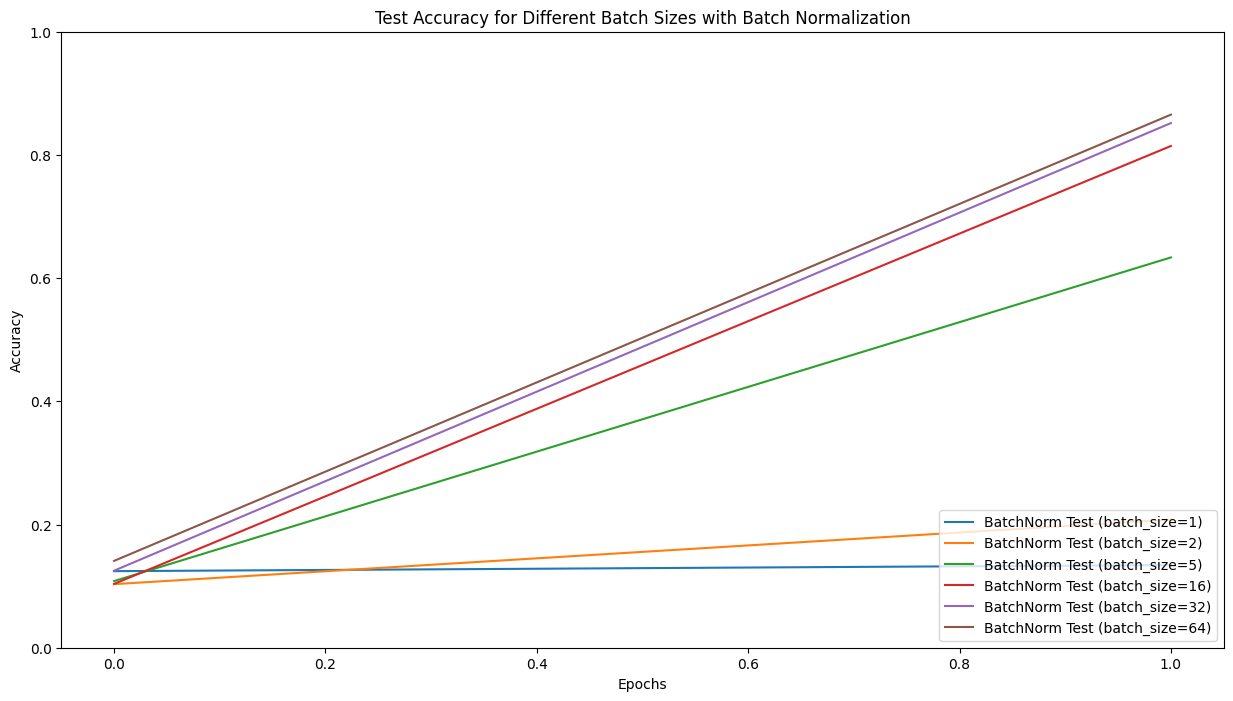

In [8]:
# 결과 저장용 딕셔너리 초기화
results = {}

# 각 배치 크기에 대해 학습 수행 및 결과 저장
for batch_size in batch_size_list:
    print(f"============== Batch Size: {batch_size} ==============")
    # __train 함수 호출
    train_acc_list, bn_train_acc_list, test_acc_list, bn_test_acc_list = __train(batch_size)
    results[batch_size] = {
        'train_acc': train_acc_list,
        'bn_train_acc': bn_train_acc_list,
        'test_acc': test_acc_list,
        'bn_test_acc': bn_test_acc_list
    }

# 그래프 그리기==========
x = np.arange(max_epochs)

# 훈련 정확도 그래프
plt.figure(figsize=(15, 8))
for batch_size in batch_size_list:
    plt.plot(x, results[batch_size]['bn_train_acc'], label=f'BatchNorm Train (batch_size={batch_size})', markevery=2)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("Train Accuracy for Different Batch Sizes with Batch Normalization")
plt.show()

# 테스트 정확도 그래프
plt.figure(figsize=(15, 8))
for batch_size in batch_size_list:
    plt.plot(x, results[batch_size]['bn_test_acc'], label=f'BatchNorm Test (batch_size={batch_size})', markevery=2)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("Test Accuracy for Different Batch Sizes with Batch Normalization")
plt.show()

### 오버피팅 방지     

### 가중치 감소  

In [15]:
class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2) # 가중치 감소 방법으로 L2 법칙을 사용
            #weight_decay += self.weight_decay_lambda * np.sum(np.abs(W))      # 가중치 감소 방법으로 L1 법칙을 사용

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # def numerical_gradient(self, x, t):
    #     """기울기를 구한다(수치 미분).
        
    #     Parameters
    #     ----------
    #     x : 입력 데이터
    #     t : 정답 레이블
        
    #     Returns
    #     -------
    #     각 층의 기울기를 담은 딕셔너리(dictionary) 변수
    #         grads['W1']、grads['W2']、... 각 층의 가중치
    #         grads['b1']、grads['b2']、... 각 층의 편향
    #     """
    #     loss_W = lambda W: self.loss(x, t)

    #     grads = {}
    #     for idx in range(1, self.hidden_layer_num+2):
    #         grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
    #         grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

    #     return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


### L2 norm

In [28]:
# 가중치 감소, Weight Decay

(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [ ]:


# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우

weight_decay_lambda = 0.01 # lambda값을 0.1로 설정
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
l2_train_acc_list = []
l2_test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        l2_train_acc_list.append(train_acc)
        l2_test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, l2_train_acc_list, marker='o', label='train', markevery=10, color='blue')
plt.plot(x, l2_test_acc_list, marker='s', label='test', markevery=10, color='green')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

epoch:0, train acc:0.08666666666666667, test acc:0.0929
epoch:1, train acc:0.11333333333333333, test acc:0.0924
epoch:2, train acc:0.14666666666666667, test acc:0.1028
epoch:3, train acc:0.15666666666666668, test acc:0.1126
epoch:4, train acc:0.18, test acc:0.123
epoch:5, train acc:0.18333333333333332, test acc:0.1312
epoch:6, train acc:0.2, test acc:0.1392
epoch:7, train acc:0.21333333333333335, test acc:0.147
epoch:8, train acc:0.22333333333333333, test acc:0.1559
epoch:9, train acc:0.23666666666666666, test acc:0.1709
epoch:10, train acc:0.28, test acc:0.1887
epoch:11, train acc:0.29, test acc:0.2045
epoch:12, train acc:0.30333333333333334, test acc:0.223
epoch:13, train acc:0.3433333333333333, test acc:0.234
epoch:14, train acc:0.36333333333333334, test acc:0.2454
epoch:15, train acc:0.39, test acc:0.2759
epoch:16, train acc:0.4266666666666667, test acc:0.3047
epoch:17, train acc:0.5, test acc:0.3384
epoch:18, train acc:0.4766666666666667, test acc:0.3231
epoch:19, train acc:0.54, 

KeyboardInterrupt: 

In [18]:
# 데이터 로드
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

# 가중치 감쇠(lambda) 값 리스트
weight_decay_lambdas = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9]

# 결과 저장용 딕셔너리 초기화
results = {}

# 반복문을 통해 각 lambda 값에 대해 학습 수행
for weight_decay_lambda in weight_decay_lambdas:
    # 네트워크와 옵티마이저 초기화
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                            weight_decay_lambda=weight_decay_lambda)
    optimizer = SGD(lr=0.01)  # 학습률이 0.01인 SGD로 매개변수 갱신

    max_epochs = 100
    train_size = x_train.shape[0]
    batch_size = 100

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

            print(f"lambda: {weight_decay_lambda}, epoch: {epoch_cnt}, train acc: {train_acc}, test acc: {test_acc}")

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    # 결과 저장
    results[weight_decay_lambda] = {
        'train_acc': train_acc_list,
        'test_acc': test_acc_list
    }



lambda: 0.001, epoch: 0, train acc: 0.15103333333333332, test acc: 0.1531
lambda: 0.001, epoch: 1, train acc: 0.8950666666666667, test acc: 0.903
lambda: 0.001, epoch: 2, train acc: 0.9250333333333334, test acc: 0.9268
lambda: 0.001, epoch: 3, train acc: 0.9374, test acc: 0.9368
lambda: 0.001, epoch: 4, train acc: 0.9472666666666667, test acc: 0.9452
lambda: 0.001, epoch: 5, train acc: 0.9513166666666667, test acc: 0.9478
lambda: 0.001, epoch: 6, train acc: 0.95445, test acc: 0.9494
lambda: 0.001, epoch: 7, train acc: 0.9611333333333333, test acc: 0.9546
lambda: 0.001, epoch: 8, train acc: 0.9637, test acc: 0.958
lambda: 0.001, epoch: 9, train acc: 0.9668666666666667, test acc: 0.9593


KeyboardInterrupt: 

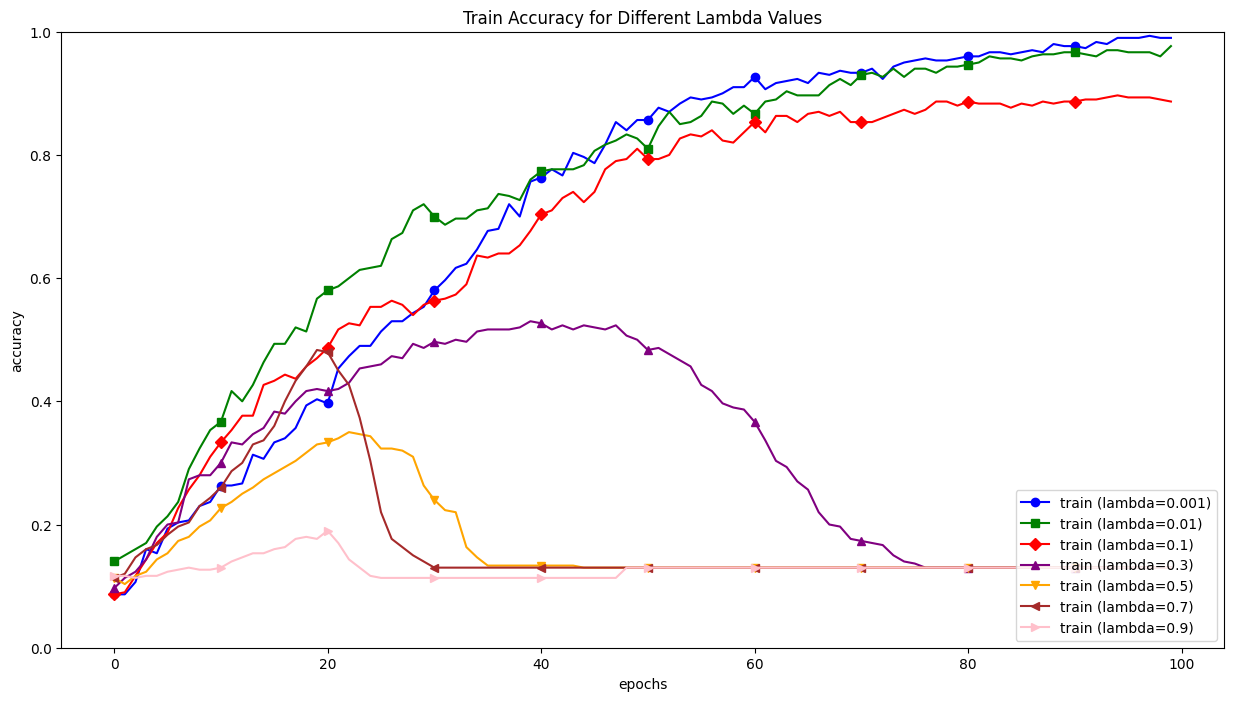

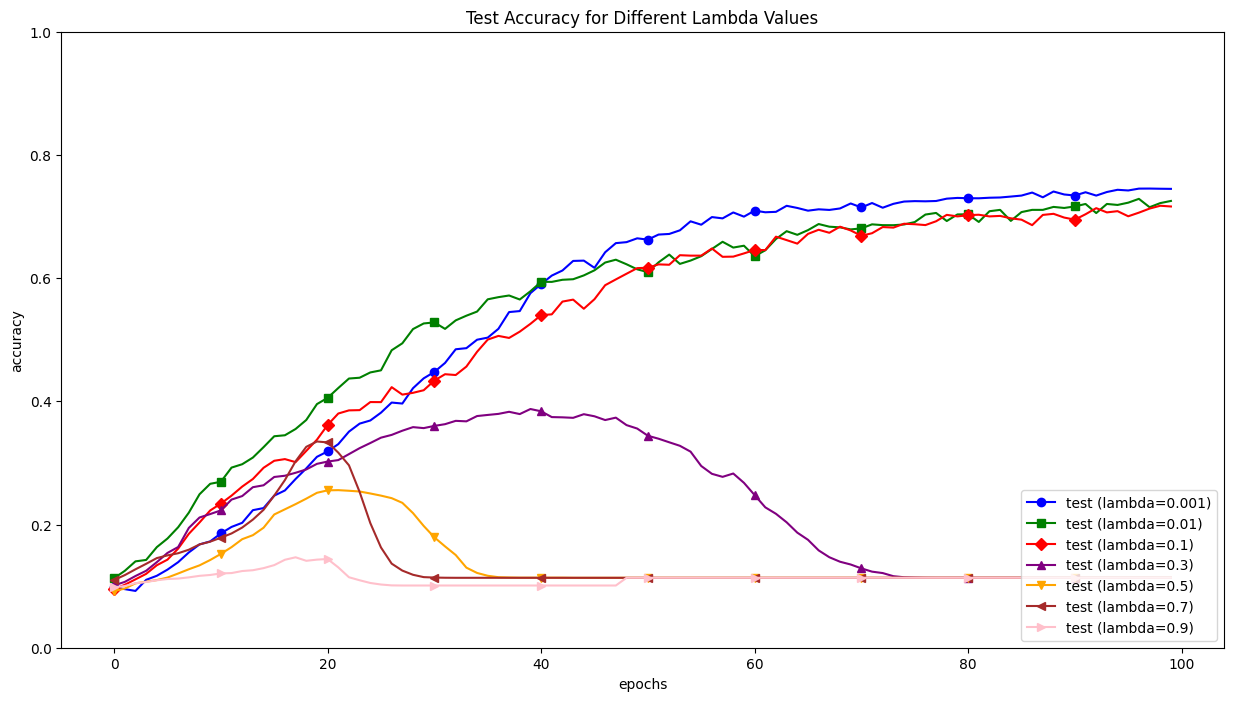

In [30]:
# 그래프 그리기
markers = ['o', 's', 'D', '^', 'v', '<', '>']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']
x = np.arange(max_epochs)

# 훈련 정확도 그래프
plt.figure(figsize=(15, 8))
for idx, weight_decay_lambda in enumerate(weight_decay_lambdas):
    plt.plot(x, results[weight_decay_lambda]['train_acc'], marker=markers[idx], label=f'train (lambda={weight_decay_lambda})', markevery=10, color=colors[idx])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("Train Accuracy for Different Lambda Values")
plt.show()

# 테스트 정확도 그래프
plt.figure(figsize=(15, 8))
for idx, weight_decay_lambda in enumerate(weight_decay_lambdas):
    plt.plot(x, results[weight_decay_lambda]['test_acc'], marker=markers[idx], label=f'test (lambda={weight_decay_lambda})', markevery=10, color=colors[idx])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("Test Accuracy for Different Lambda Values")
plt.show()

In [20]:
from common.trainer import Trainer

train loss:2.288149205907997
=== epoch:1, train acc:0.08333333333333333, test acc:0.118 ===
train loss:2.2778574570596035
train loss:2.285524678071857
train loss:2.2893697853957784
=== epoch:2, train acc:0.09333333333333334, test acc:0.1224 ===
train loss:2.2920721952519814
train loss:2.3059990428134394
train loss:2.2829448989205274
=== epoch:3, train acc:0.09333333333333334, test acc:0.1265 ===
train loss:2.285573148216831
train loss:2.2776666492902287
train loss:2.2917542852497585
=== epoch:4, train acc:0.1, test acc:0.1257 ===
train loss:2.2958611426321442
train loss:2.2952887220260987
train loss:2.28688614811042
=== epoch:5, train acc:0.10666666666666667, test acc:0.1304 ===
train loss:2.2851649841998425
train loss:2.2652454600258496
train loss:2.2835301888683377
=== epoch:6, train acc:0.11, test acc:0.1342 ===
train loss:2.2710479610175387
train loss:2.2903070842375626
train loss:2.28508976357475
=== epoch:7, train acc:0.11333333333333333, test acc:0.1378 ===
train loss:2.27573469

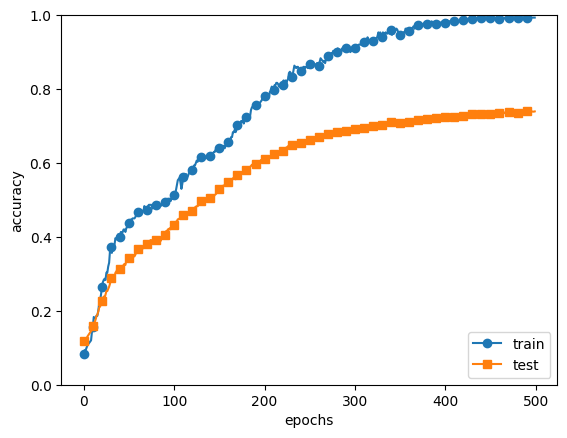

In [74]:
# 드롭아웃, Dropout

(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.15  # 책에서 설정한 값은 0.15, 0.15보다 큰 원소만 활성화 된다.
# ====================================================

# 은닉층이 6개인 신경망을 생성한다. -> hidden_size_list를 조정하면 은닉층의 개수를 조정할 수 있다.
network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.3730229857502705
=== epoch:1, train acc:0.09666666666666666, test acc:0.0963 ===
train loss:2.2499475034482805
train loss:2.299824473056296
train loss:2.2875513067586413
=== epoch:2, train acc:0.13, test acc:0.1202 ===
train loss:2.2912663469101058
train loss:2.308674228529503
train loss:2.3049412495931523
=== epoch:3, train acc:0.13666666666666666, test acc:0.1373 ===
train loss:2.2396469759235127
train loss:2.22426592865982
train loss:2.1850167969394145
=== epoch:4, train acc:0.19, test acc:0.1652 ===
train loss:2.1989510248804494
train loss:2.2465285737326783
train loss:2.1704685147806035
=== epoch:5, train acc:0.21333333333333335, test acc:0.1925 ===
train loss:2.1786913086777036
train loss:2.2405536007365647
train loss:2.155107290095975
=== epoch:6, train acc:0.25666666666666665, test acc:0.2213 ===
train loss:2.130100830250678
train loss:2.1376268440798243
train loss:2.154965192009818
=== epoch:7, train acc:0.29333333333333333, test acc:0.2437 ===
train loss:2.142956

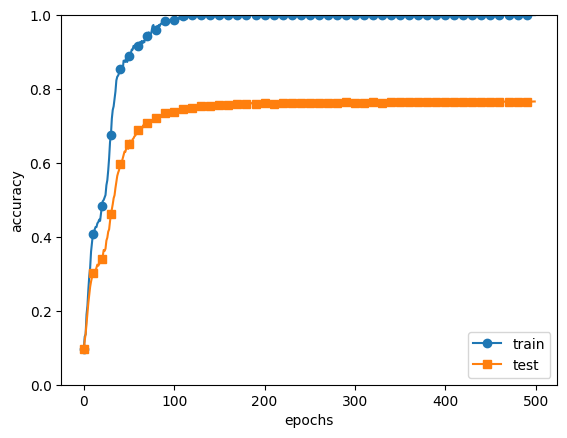

: 

In [ ]:
# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = False  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.15
# ====================================================

# 은닉층이 6개인 신경망을 생성한다. -> hidden_size_list를 조정하면 은닉층의 개수를 조정할 수 있다.
network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [ ]:
# 하이퍼파라미터 설정
input_size = 784
hidden_size_list = [100, 100, 100, 100, 100, 100]
output_size = 10
epochs = 301
mini_batch_size = 100
optimizer = 'sgd'
optimizer_param = {'lr': 0.01}

# 다양한 dropout_ratio 값 설정
dropout_ratio_list = [0.01, 0.1, 0.15, 0.3, 0.5]

results = {}

for dropout_ratio in dropout_ratio_list:
    print(f"Training with dropout_ratio={dropout_ratio}...")
    
    # 신경망 생성
    network = MultiLayerNetExtend(input_size=input_size, hidden_size_list=hidden_size_list,
                                  output_size=output_size, use_dropout=True, dropout_ration=dropout_ratio)
    
    # 트레이너 생성
    trainer = Trainer(network, x_train, t_train, x_test, t_test,
                      epochs=epochs, mini_batch_size=mini_batch_size,
                      optimizer=optimizer, optimizer_param=optimizer_param, verbose=True)
    
    # 학습
    trainer.train()
    
    # 결과 저장
    train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list
    results[dropout_ratio] = (train_acc_list, test_acc_list)

# 그래프 그리기
plt.figure(figsize=(12, 8))
for dropout_ratio, (train_acc_list, test_acc_list) in results.items():
    x = np.arange(len(train_acc_list))
    plt.plot(x, train_acc_list, marker='o', label=f'train (dropout={dropout_ratio})', markevery=10)
    plt.plot(x, test_acc_list, marker='s', label=f'test (dropout={dropout_ratio})', markevery=10)

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

Training with dropout_ratio=0.01...
train loss:2.3942095214297603
=== epoch:1, train acc:0.06971666666666666, test acc:0.0717 ===
train loss:2.3666287210932633
train loss:2.3582145221894026
train loss:2.3232735030249057
train loss:2.357141995339764
train loss:2.283567113890968
train loss:2.284760670060207
train loss:2.2871162674515704
train loss:2.316782157244764
train loss:2.265508809774379
train loss:2.2122854184365455
train loss:2.2838044324017908
train loss:2.2801323528214494
train loss:2.2225688710028284
train loss:2.224349507869446
train loss:2.2432597263945975
train loss:2.2097840141990157
train loss:2.210939945105131
train loss:2.186594515161965
train loss:2.191867203655754
train loss:2.2046349008164885
train loss:2.193031692170063
train loss:2.176870194383836
train loss:2.123711178365664
train loss:2.1297208860880676
train loss:2.1221137670838015
train loss:2.160022662780746
train loss:2.139029253735267
train loss:2.144660757291838
train loss:2.084525950148662
train loss:2.137

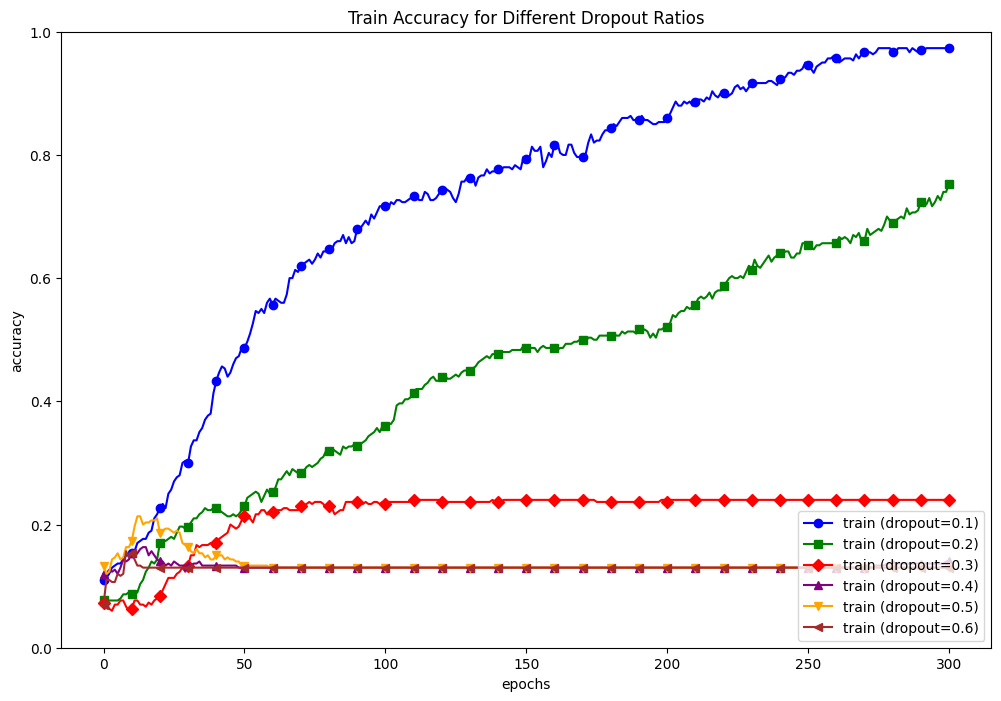

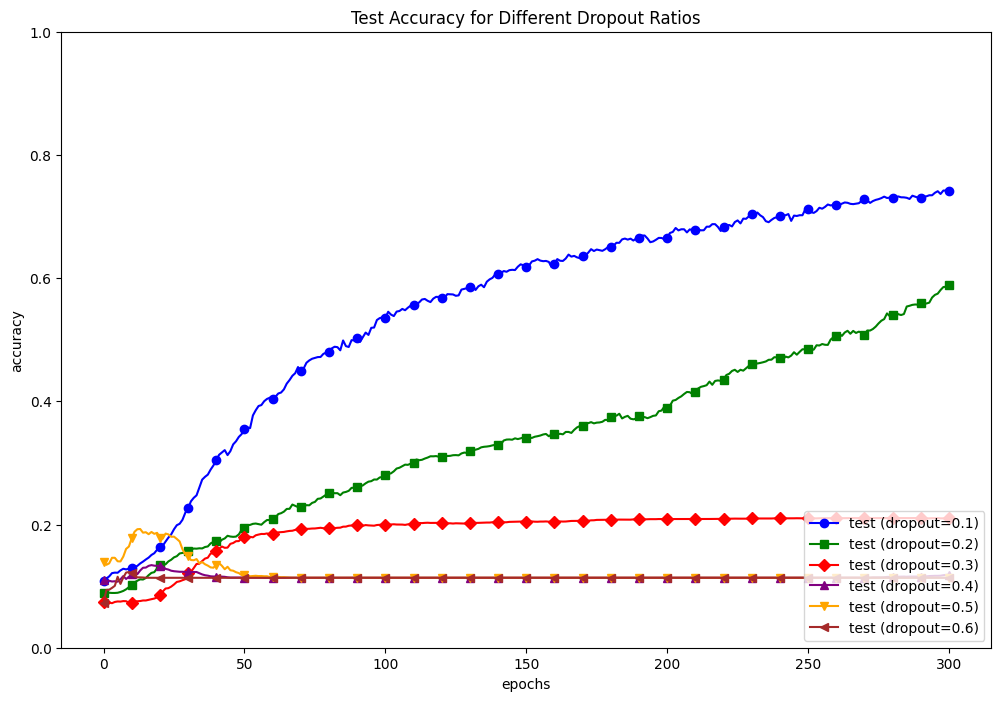

In [40]:
# 드롭아웃, Dropout

(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 비율 리스트
dropout_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# 결과 저장용 딕셔너리 초기화
results = {}

# 데이터셋 로드 (예시)
# x_train, t_train, x_test, t_test는 이미 로드된 데이터셋이라고 가정합니다.

# 반복문을 통해 각 드롭아웃 비율에 대해 학습 수행
for dropout_ratio in dropout_ratios:
    # 네트워크와 트레이너 초기화
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                                  output_size=10, use_dropout=True, dropout_ration=dropout_ratio)
    trainer = Trainer(network, x_train, t_train, x_test, t_test,
                      epochs=301, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=False)
    trainer.train()

    # 결과 저장
    train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list
    results[dropout_ratio] = {
        'train_acc': train_acc_list,
        'test_acc': test_acc_list
    }

# 그래프 그리기
markers = ['o', 's', 'D', '^', 'v', '<', '>']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']
x = np.arange(len(train_acc_list))

# 훈련 정확도 그래프
plt.figure(figsize=(12, 8))
for idx, dropout_ratio in enumerate(dropout_ratios):
    plt.plot(x, results[dropout_ratio]['train_acc'], marker=markers[idx], label=f'train (dropout={dropout_ratio})', markevery=10, color=colors[idx])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("Train Accuracy for Different Dropout Ratios")
plt.show()

# 테스트 정확도 그래프
plt.figure(figsize=(12, 8))
for idx, dropout_ratio in enumerate(dropout_ratios):
    plt.plot(x, results[dropout_ratio]['test_acc'], marker=markers[idx], label=f'test (dropout={dropout_ratio})', markevery=10, color=colors[idx])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title("Test Accuracy for Different Dropout Ratios")
plt.show()

### 하이퍼파라미터 최적화 구현  

In [22]:
from common.util import shuffle_dataset

val acc:0.09 | lr:6.574582419200072e-06, weight decay:3.057814655543888e-05
val acc:0.12 | lr:5.31417553145557e-06, weight decay:3.124937684858803e-06
val acc:0.73 | lr:0.0072954813176153484, weight decay:5.516997090280344e-06
val acc:0.06 | lr:1.170348139104676e-06, weight decay:3.893467302074838e-08
val acc:0.32 | lr:0.0015133065905960715, weight decay:7.531237028507283e-05
val acc:0.77 | lr:0.00902677066828107, weight decay:6.918674507640696e-08
val acc:0.08 | lr:5.017054775332703e-06, weight decay:1.2037904653438724e-08
val acc:0.69 | lr:0.006972599493436597, weight decay:6.181342463276302e-07
val acc:0.12 | lr:1.5897295000356635e-06, weight decay:1.3706319486300148e-06
val acc:0.13 | lr:0.0001954480904688054, weight decay:2.4731668540047666e-08
val acc:0.22 | lr:0.0010079072561652099, weight decay:4.5371084407825066e-05
val acc:0.04 | lr:4.3744869573526236e-05, weight decay:1.3973088365390778e-06
val acc:0.19 | lr:2.305821780701876e-06, weight decay:2.323327530703243e-08
val acc:0

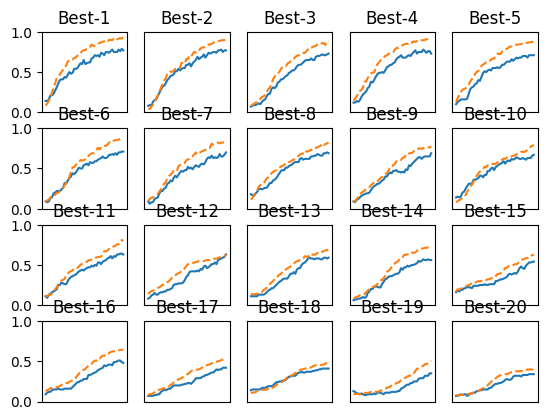

In [17]:
(x_train, t_train), (x_test, t_test) = mnist.load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()